# libraries

In [1]:
# Core Keras libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
 

# For data conditioning
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt


# Make results reproducible
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)


# Other essential libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from numpy import array
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [2]:
# Set input number of timestamps and training hours
n_timestamp = 7
n_epochs = 30
filter_on = 1


# Select model type
# 1: Single cell
# 2: Stacked
# 3: Bidirectional
#
model_type = 2


# preparing data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

train_set = pd.read_csv('/content/drive/MyDrive/ECSE552/weather_train.csv')
test_set = pd.read_csv('/content/drive/MyDrive/ECSE552/weather_test.csv')

pressure_pred = pd.read_csv('/content/drive/MyDrive/ECSE552/pressure_data.csv')
temperature_pred = pd.read_csv('/content/drive/MyDrive/ECSE552/temperature_data.csv')

if filter_on == 1:
    
    train_set['T (degC)'] = medfilt(train_set['T (degC)'], 3)
    train_set['T (degC)'] = gaussian_filter1d(train_set['T (degC)'], 1.2)

if filter_on == 1:
    
    test_set['T (degC)'] = medfilt(test_set['T (degC)'], 3)
    test_set['T (degC)'] = gaussian_filter1d(test_set['T (degC)'], 1.2)


# [['p (mbar)', 'T (degC)', 'rh (%)', 'wv (m/s)']]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Set number of training and testing data
train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)


# change these 2 lines according to the features (pressure, temperature, humidity, wind velocity)
# 1) pressure
training_set = train_set.iloc[:, 1:2].values
testing_set = test_set.iloc[:, 1:2].values

# 2) temperature
training_set = train_set.iloc[:, 2:3].values
testing_set = test_set.iloc[:, 2:3].values

# 3) humidity
# training_set = train_set.iloc[:, 5:6].values
# testing_set = test_set.iloc[:, 5:6].values

# 4) velocity
# training_set = train_set.iloc[:, 12:13].values
# testing_set = test_set.iloc[:, 12:13].values



# Normalize data (pre-processing) 
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.fit_transform(testing_set)

In [5]:
# Split data into n_timestamp
def data_split(sequence, n_timestamp):
    X = []
    y = []
    for i in range(len(sequence)):
        end_ix = i + n_timestamp
        if end_ix > len(sequence)-1:
            break
        # i to end_ix as input
        # end_ix as target output
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)


X_train, y_train = data_split(training_set_scaled, n_timestamp)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_test, y_test = data_split(testing_set_scaled, n_timestamp)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_test.shape

(14012, 7, 1)

# model

In [6]:
if model_type == 1: # this model was tested but not used
    # Single cell LSTM 
    model = Sequential()
    model.add(LSTM(units = 50, activation='relu',input_shape = (X_train.shape[1], 1)))
    model.add(Dense(units = 1))
if model_type == 2: # this model is used 
    # Stacked LSTM
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
if model_type == 3: # this model was tested but not used
    # Bidirectional LSTM
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))

# train & test

In [7]:
# Start training
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train, y_train, epochs = n_epochs, batch_size = 32)
loss = history.history['loss']
epochs = range(len(loss))


# Get predicted data
y_predicted = model.predict(X_test)


# 'De-normalize' the data
y_predicted_descaled = sc.inverse_transform(y_predicted)
y_train_descaled = sc.inverse_transform(y_train)
y_test_descaled = sc.inverse_transform(y_test)
y_pred = y_predicted.ravel()
y_pred = [round(yx, 2) for yx in y_pred]
y_tested = y_test.ravel()


Epoch 1/30
1753/1753 [==============================] - 36s 18ms/step - loss: 0.0056
Epoch 2/30
1753/1753 [==============================] - 17s 10ms/step - loss: 3.1946e-04
Epoch 3/30
1753/1753 [==============================] - 17s 10ms/step - loss: 1.4033e-04
Epoch 4/30
1753/1753 [==============================] - 17s 10ms/step - loss: 5.8635e-05
Epoch 5/30
1753/1753 [==============================] - 17s 10ms/step - loss: 4.3562e-05
Epoch 6/30
1753/1753 [==============================] - 17s 10ms/step - loss: 3.3225e-05
Epoch 7/30
1753/1753 [==============================] - 18s 10ms/step - loss: 2.7923e-05
Epoch 8/30
1753/1753 [==============================] - 17s 10ms/step - loss: 2.5624e-05
Epoch 9/30
1753/1753 [==============================] - 17s 10ms/step - loss: 2.1237e-05
Epoch 10/30
1753/1753 [==============================] - 17s 10ms/step - loss: 1.5961e-05
Epoch 11/30
1753/1753 [==============================] - 17s 10ms/step - loss: 1.5009e-05
Epoch 12/30
1753/1753 [

In [ ]:
# save numpy array as csv file (DO NOT run)
from numpy import asarray
from numpy import savetxt
# save to csv file
savetxt('temperature_data.csv', y_predicted)

# results

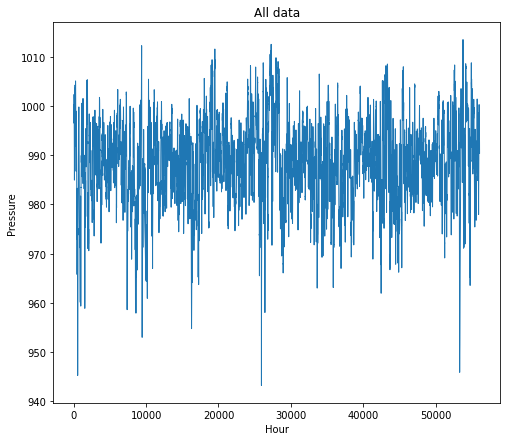

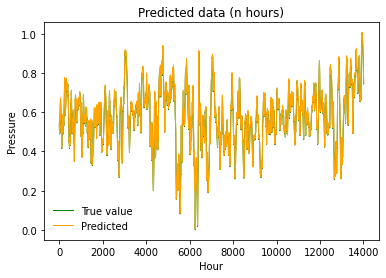

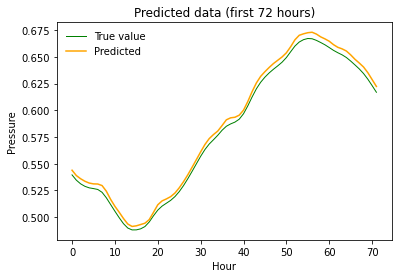

mse=2.628164600594903e-05
r2=0.9987177111940508


In [ ]:
# Results for Pressure
plt.figure(figsize=(8,7))

plt.plot(train_set['p (mbar)'], linewidth=1, label = 'True value')
plt.ylabel("Pressure")
plt.xlabel("Hour")
plt.title("All data")
plt.show()

plt.plot(y_test, color = 'green', linewidth=1, label = 'True value')
plt.plot(y_predicted, color = 'orange',  linewidth=1, label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Pressure")
plt.xlabel("Hour")
plt.title("Predicted data (n hours)")
plt.show()

plt.plot(y_test[0:72], color = 'green', linewidth=1, label = 'True value')
plt.plot(y_predicted[0:72], color = 'orange', label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Pressure")
plt.xlabel("Hour")
plt.title("Predicted data (first 72 hours)")
plt.show()



mse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test_descaled, y_predicted_descaled)
print("mse=" + str(mse))
print("r2=" + str(r2))

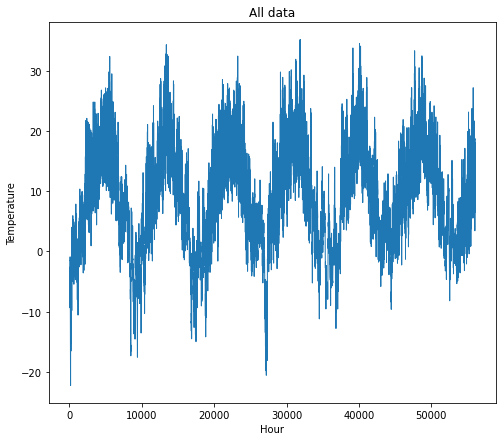

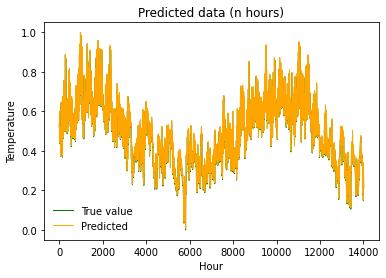

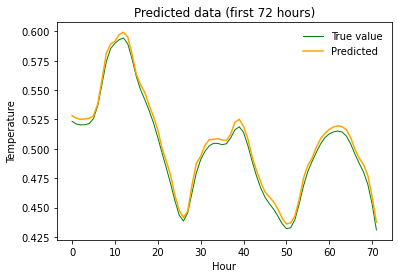

mse=2.3101552022190387e-05
r2=0.9991055650858376


In [ ]:
# Results for Temperature
plt.figure(figsize=(8,7))

plt.plot(train_set['T (degC)'], linewidth=1, label = 'True value')
plt.ylabel("Temperature")
plt.xlabel("Hour")
plt.title("All data")
plt.show()

plt.plot(y_test, color = 'green', linewidth=1, label = 'True value')
plt.plot(y_predicted, color = 'orange',  linewidth=1, label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Hour")
plt.title("Predicted data (n hours)")
plt.show()

plt.plot(y_test[0:72], color = 'green', linewidth=1, label = 'True value')
plt.plot(y_predicted[0:72], color = 'orange', label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Temperature")
plt.xlabel("Hour")
plt.title("Predicted data (first 72 hours)")
plt.show()



mse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test_descaled, y_predicted_descaled)
print("mse=" + str(mse))
print("r2=" + str(r2))

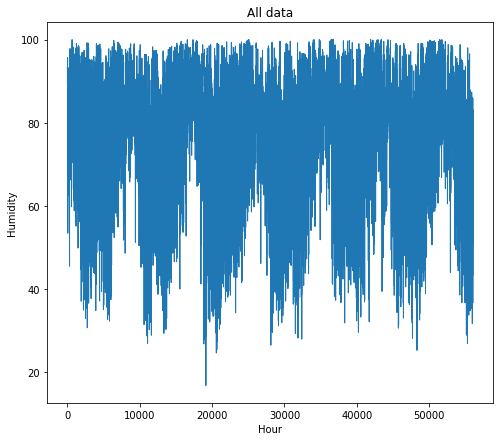

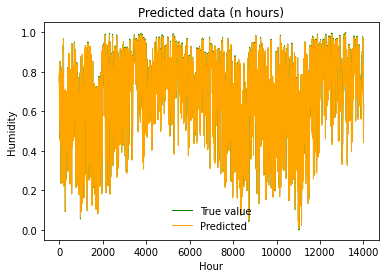

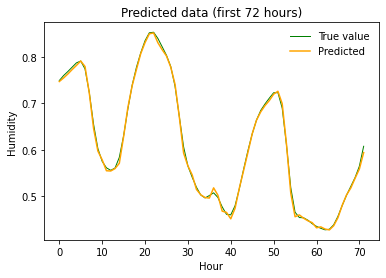

mse=2.6560879976591574e-05
r2=0.9993945683071945


In [ ]:
# Results for Humidity
plt.figure(figsize=(8,7))

plt.plot(train_set['rh (%)'], linewidth=1, label = 'True value')
plt.ylabel("Humidity")
plt.xlabel("Hour")
plt.title("All data")
plt.show()

plt.plot(y_test, color = 'green', linewidth=1, label = 'True value')
plt.plot(y_predicted, color = 'orange',  linewidth=1, label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Humidity")
plt.xlabel("Hour")
plt.title("Predicted data (n hours)")
plt.show()

plt.plot(y_test[0:72], color = 'green', linewidth=1, label = 'True value')
plt.plot(y_predicted[0:72], color = 'orange', label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Humidity")
plt.xlabel("Hour")
plt.title("Predicted data (first 72 hours)")
plt.show()



mse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test_descaled, y_predicted_descaled)
print("mse=" + str(mse))
print("r2=" + str(r2))

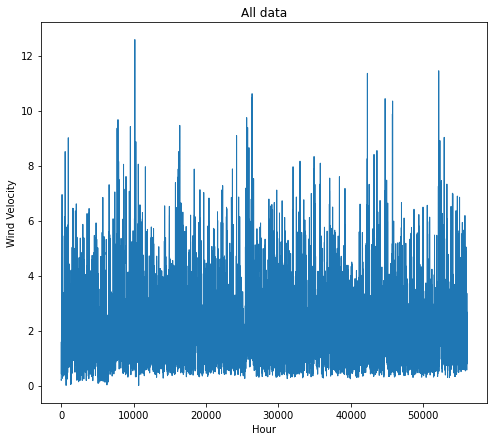

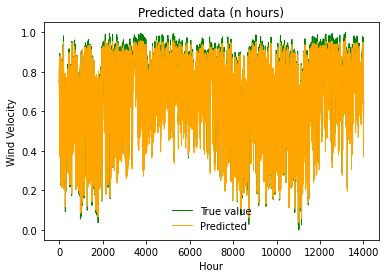

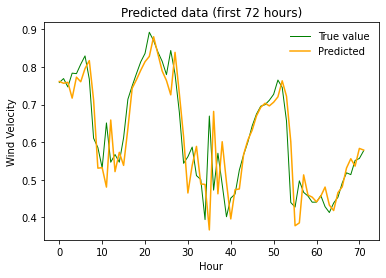

mse=0.0027875214198303635
r2=0.9394303675221569


In [ ]:
# Results for Wind Velocity
plt.figure(figsize=(8,7))

plt.plot(train_set['wv (m/s)'], linewidth=1, label = 'True value')
plt.ylabel("Wind Velocity")
plt.xlabel("Hour")
plt.title("All data")
plt.show()

ax = plt.gca()
# ax.set_ylim([0.995, 1])
plt.plot(y_test, color = 'green', linewidth=1, label = 'True value')
plt.plot(y_predicted, color = 'orange',  linewidth=1, label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Wind Velocity")
plt.xlabel("Hour")
plt.title("Predicted data (n hours)")
plt.show()

plt.plot(y_test[0:72], color = 'green', linewidth=1, label = 'True value')
plt.plot(y_predicted[0:72], color = 'orange', label = 'Predicted')
plt.legend(frameon=False)
plt.ylabel("Wind Velocity")
plt.xlabel("Hour")
plt.title("Predicted data (first 72 hours)")
plt.show()



mse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)
print("mse=" + str(mse))
print("r2=" + str(r2))


# error propagation

In [ ]:
# atmospheric pressure
input = X_test
label = y_test

for i in range(10):
    # Get predicted data
    y_predicted = model.predict(input)

    mse = mean_squared_error(label, y_predicted)
    print("Iteration " + str(i) + " => MSE = " + str(mse))
    
    new_test_set = sc.fit_transform(y_predicted)
    input, label = data_split(new_test_set, n_timestamp)


Iteration 0 => MSE = 2.628164600594903e-05
Iteration 1 => MSE = 2.8459015e-05
Iteration 2 => MSE = 5.15826e-05
Iteration 3 => MSE = 0.00034960313
Iteration 4 => MSE = 0.0030410325
Iteration 5 => MSE = 0.007251774
Iteration 6 => MSE = 0.01640618
Iteration 7 => MSE = 0.033632714
Iteration 8 => MSE = 0.07049335
Iteration 9 => MSE = 0.1601659


In [ ]:
# temperature
input = X_test
label = y_test

for i in range(10):
    # Get predicted data
    y_predicted = model.predict(input)

    mse = mean_squared_error(label, y_predicted)
    print("Iteration " + str(i) + " => MSE = " + str(mse))
    
    new_test_set = sc.fit_transform(y_predicted)
    input, label = data_split(new_test_set, n_timestamp)


Iteration 0 => MSE = 2.3101552022190387e-05
Iteration 1 => MSE = 0.00010889141
Iteration 2 => MSE = 0.0088474555
Iteration 3 => MSE = 0.16803558
Iteration 4 => MSE = 0.22061102
Iteration 5 => MSE = 0.16312294
Iteration 6 => MSE = 0.10494066
Iteration 7 => MSE = 0.0892386
Iteration 8 => MSE = 0.088392794
Iteration 9 => MSE = 0.0915084


In [ ]:
# humidity
input = X_test
label = y_test

for i in range(10):
    # Get predicted data
    y_predicted = model.predict(input)

    mse = mean_squared_error(label, y_predicted)
    print("Iteration " + str(i) + " => MSE = " + str(mse))
    
    new_test_set = sc.fit_transform(y_predicted)
    input, label = data_split(new_test_set, n_timestamp)

Iteration 0 => MSE = 2.6560879976591574e-05
Iteration 1 => MSE = 0.0009517248
Iteration 2 => MSE = 0.062710695
Iteration 3 => MSE = 0.33310217
Iteration 4 => MSE = 0.23343498
Iteration 5 => MSE = 0.1450046
Iteration 6 => MSE = 0.10958441
Iteration 7 => MSE = 0.09633034
Iteration 8 => MSE = 0.09226476
Iteration 9 => MSE = 0.09224709


In [ ]:
# wind velocity 
input = X_test
label = y_test

for i in range(10):
    # Get predicted data
    y_predicted = model.predict(input)

    mse = mean_squared_error(label, y_predicted)
    print("Iteration " + str(i) + " => MSE = " + str(mse))
    
    new_test_set = sc.fit_transform(y_predicted)
    input, label = data_split(new_test_set, n_timestamp)

Iteration 0 => MSE = 0.0027875214198303635
Iteration 1 => MSE = 0.0048622596
Iteration 2 => MSE = 0.008547833
Iteration 3 => MSE = 0.013838604
Iteration 4 => MSE = 0.020451657
Iteration 5 => MSE = 0.027841032
Iteration 6 => MSE = 0.034938887
Iteration 7 => MSE = 0.040496178
Iteration 8 => MSE = 0.04534147
Iteration 9 => MSE = 0.049516626


# further analysis

In [8]:
# Predicting today's weather 
input = X_test[:-12]
label = y_test[12:]

y_predicted = model.predict(input)

mse_td = mean_squared_error(label, y_predicted)
print("Mean Squared Error (Atmospheric pressure - today) = " + str(mse_td))



print("*************************** " )



# Predicting tomorrow's weather 
input = X_test[:-24]
label = y_test[24:]

y_predicted = model.predict(input)

mse_t = mean_squared_error(label, y_predicted)
print("Mean Squared Error ((Atmospheric pressure) - tomorrow) = " + str(mse_t))



print("*************************** " )



# Predicting next week's weather
input = X_test[:-24*7]
label = y_test[24*7:]

y_predicted = model.predict(input)

mse_w = mean_squared_error(label, y_predicted)
print("Mean Squared Error ((Atmospheric pressure) - next week) = " + str(mse_w))

Mean Squared Error (Atmospheric pressure - today) = 0.003511774691673574
*************************** 
Mean Squared Error ((Atmospheric pressure) - tomorrow) = 0.009199156864876159
*************************** 
Mean Squared Error ((Atmospheric pressure) - next week) = 0.037438492973681584


In [9]:
# Predicting today's weather 
input = X_test[:-12]
label = y_test[12:]

y_predicted = model.predict(input)

mse_td = mean_squared_error(label, y_predicted)
print("Mean Squared Error (Air temperature - today) = " + str(mse_td))



print("*************************** " )


# Predicting tomorrow's weather 
input = X_test[:-24]
label = y_test[24:]

y_predicted = model.predict(input)

mse_t = mean_squared_error(label, y_predicted)
print("Mean Squared Error ((Air temperature) - tomorrow) = " + str(mse_t))



print("*************************** " )



# Predicting next week's weather
input = X_test[:-24*7]
label = y_test[24*7:]

y_predicted = model.predict(input)

mse_w = mean_squared_error(label, y_predicted)
print("Mean Squared Error ((Air temperature) - next week) = " + str(mse_w))

Mean Squared Error (Air temperature - today) = 0.01193855917216975
*************************** 
Mean Squared Error ((Air temperature) - tomorrow) = 0.004311540868201481
*************************** 
Mean Squared Error ((Air temperature) - next week) = 0.014222664729828966


In [9]:
# Predicting today's weather 
input = X_test[:-12]
label = y_test[12:]

y_predicted = model.predict(input)

mse_td = mean_squared_error(label, y_predicted)
print("Mean Squared Error (Relative humidity - today) = " + str(mse_td))



print("*************************** " )



# Predicting tomorrow's weather 
input = X_test[:-24]
label = y_test[24:]

y_predicted = model.predict(input)

mse_t = mean_squared_error(label, y_predicted)
print("Mean Squared Error ((Relative humidity) - tomorrow) = " + str(mse_t))



print("*************************** " )



# Predicting next week's weather
input = X_test[:-24*7]
label = y_test[24*7:]

y_predicted = model.predict(input)

mse_w = mean_squared_error(label, y_predicted)
print("Mean Squared Error ((Relative humidity) - next week) = " + str(mse_w))

Mean Squared Error (Relative humidity - today) = 0.07622991584683726
*************************** 
Mean Squared Error ((Relative humidity) - tomorrow) = 0.028097527817258484
*************************** 
Mean Squared Error ((Relative humidity) - next week) = 0.04110070350845241


In [13]:
# Predicting today's weather 
input = X_test[:-12]
label = y_test[12:]

y_predicted = model.predict(input)

mse_td = mean_squared_error(label, y_predicted)
print("Mean Squared Error (Wind velocity - today) = " + str(mse_td))



print("*************************** " )


# Predicting tomorrow's weather 
input = X_test[:-24]
label = y_test[24:]

y_predicted = model.predict(input)

mse_t = mean_squared_error(label, y_predicted)
print("Mean Squared Error (Wind velocity - tomorrow) = " + str(mse_t))



print("*************************** " )



# Predicting next week's weather
input = X_test[:-24*7]
label = y_test[24*7:]

y_predicted = model.predict(input)

mse_w = mean_squared_error(label, y_predicted)
print("Mean Squared Error (Wind velocity - next week) = " + str(mse_w))

Mean Squared Error (Atmospheric pressure - today) = 0.0004676485879787665
*************************** 
Mean Squared Error (Atmospheric pressure - tomorrow) = 0.00046815361823019465
*************************** 
Mean Squared Error (Atmospheric pressure - next week) = 0.00047212096707140774


# Gay-Lussac's law

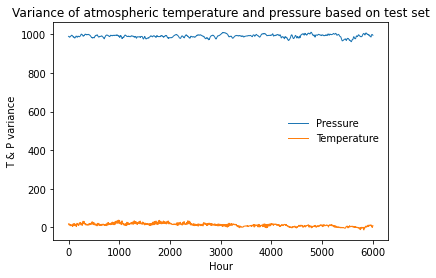

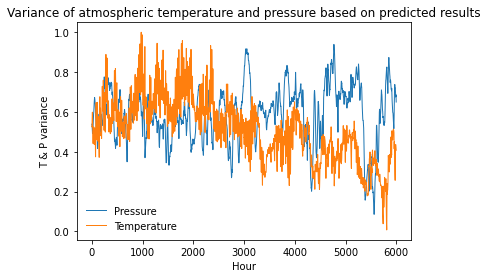

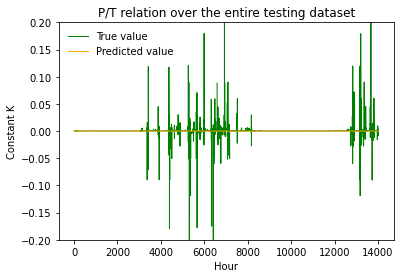

Mean Squared Error for the first 4000 values = 1.0844479294164077e-05


In [ ]:
k1 = []
k1 = test_set['p (mbar)']*0.0009869/ (test_set['T (degC)']*274.15)  # converting units to atm and kelvin
k1.shape



series_pressure = pressure_pred.squeeze()
series_temperature = temperature_pred.squeeze()
k2 = series_pressure*0.0009869 / (series_temperature*274.15)   # converting units to atm and kelvin

plt.plot(test_set['p (mbar)'][:6000], linewidth=1, label = 'Pressure')
plt.plot(test_set['T (degC)'][:6000], linewidth=1, label = 'Temperature')
plt.legend(frameon=False)
plt.ylabel("T & P variance")
plt.xlabel("Hour")
plt.title("Variance of atmospheric temperature and pressure based on test set")
plt.show()

plt.plot(series_pressure[:6000], linewidth=1, label = 'Pressure')
plt.plot(series_temperature[:6000], linewidth=1, label = 'Temperature')
plt.legend(frameon=False)
plt.ylabel("T & P variance")
plt.xlabel("Hour")
plt.title("Variance of atmospheric temperature and pressure based on predicted results")
plt.show()


ax = plt.gca()
ax.set_ylim([-0.2, 0.2])
plt.plot(k1, color = 'green', linewidth=1, label = 'True value')
plt.plot(k2, color = 'orange', linewidth=1, label = 'Predicted value')
plt.legend(frameon=False)
plt.ylabel("Constant K")
plt.xlabel("Hour")
plt.title("P/T relation over the entire testing dataset")
plt.show()


mse = mean_squared_error(k1[:4000], k2[:4000])
print("Mean Squared Error for the first 4000 values = " + str(mse))

In [ ]:
test_set['T (degC)']

0        17.93
1        16.92
2        15.82
3        15.02
4        14.14
         ...  
14014    -0.98
14015    -1.40
14016    -2.75
14017    -2.89
14018    -3.93
Name: T (degC), Length: 14019, dtype: float64